In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
sb.set()  # seaborn style plots
from sklearn import linear_model

In [2]:
ds = pd.read_csv('close_shots_ASPNF2019.txt', delimiter='\s+', index_col='shots')

In [3]:
print(f'During the ASPNF2019, {len(ds)} GOLEM shots have been performed by 5 groups of students')

During the ASPNF2019, 70 GOLEM shots have been performed by 5 groups of students


# Confinement Time scaling with density

Here we focus on the evolution of the confinement time with respect to the density. The density is got from the equilibrium density signal in GOLEM. The plasma electron confinement time also.

In [4]:
# rescale the date to more convenient units
ds['tau_e_us'] = 1e6*ds.electron_confinement_time
ds['ne'] = ds.electron_density_equilibrium/1e18
ds2 = ds[['ne', 'tau_e_us']].dropna()

In [5]:
# fit the data with a robust linear model (which filters the outliers)
lm = linear_model.RANSACRegressor().fit(ds2[['ne']], ds2['tau_e_us']) 
ds2['lin_reg'] = lm.predict(ds2[['ne']])

In [6]:
# plotting the data and the fitting curve
ax = ds2.plot(kind='scatter', x='ne', y='tau_e_us', ylim=(0,50))
ds2.plot(x='ne', y='lin_reg', color='k', ax=ax, label=None)

ax.set_ylabel(r'Confinement time $\tau_e$ [µs]', fontsize=12)
ax.set_xlabel('Electron Density $n_e$ [$10^{18} m^{-3}$]', fontsize=12)
ax.set_title('ASPNF2019 GOLEM Plasmas')
plt.grid(True)
ax.text(2, 30, r'$\hat \tau_e$'+f'={lm.estimator_.coef_[0]:.2} $\hat n_e$ + {lm.estimator_.intercept_:.2}')


<IPython.core.display.Javascript object>

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(2, 30, '$\\hat \\tau_e$=3.0 $\\hat n_e$ + 3.7')

# Fitting the Neo Alcator confinement time scaling

The latter fit as linear density behavior, like in the Neo-Alcator scaling law which is [Goldston, Plasma Phys. Control. Fusion 26 (1984) 87].:
$$
\tau_e = 7.1 \times 10^{-22} \bar n_e a^{1.04} R^{2.04} \sqrt{q(a)}
$$
where
$$
q(a) = \frac{a B_t}{R B_p} \approx \frac{2\pi a^2 B_t}{\mu_0 I_p R_0}
$$

where we have used the plasma current derivation from Maxwell-Ampere:
$$
I_p = 2\pi a B_p / \mu_0
$$



Below we compare the analytical expression with the measured data. We adjusted manually the plasma radisu $a$ of GOLEM in order to fit both data

In [7]:
from scipy.constants import mu_0
a = 35e-3 # should be ~60e-3 
R0 = 0.4
ds['qa'] = 2 * np.pi * a**2 * ds['toroidal_field_mean'] / (mu_0 * ds['plasma_current_mean']*R0)
ds['tau_e_na'] = 7.1e-22 * ds['electron_density_equilibrium'] * a**1.04 * R0**2.04 * np.sqrt(ds['qa'])

In [8]:
ax=ds.plot(kind='scatter', x='electron_density_equilibrium', y='electron_confinement_time', label='GOLEM')
ds.plot(kind='scatter', x='electron_density_equilibrium', y='tau_e_na', ax=ax, color='r', label='Neo Alcator ($a$ adjusted)')
ax.set_ylim(0, 50e-6)
ax.set_ylabel(r'Confinement time $\tau_e$ [s]', fontsize=12)
ax.set_xlabel('Electron Density $n_e$ [$m^{-3}$]', fontsize=12)
ax.set_title('ASPNF2019 GOLEM Plasmas')
plt.tight_layout()

<IPython.core.display.Javascript object>

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Conclusion : the Neo Alcator would fit well assuming a smaller plasma radius of ~35 mm instead of 60 mm as expected...

# How to optimize the plasma duration

In [9]:
ds.hist('plasma_life', bins=len(ds))

<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BDC8B70>]],
      dtype=object)

In [10]:
fig, ax = plt.subplots()
sb.distplot(1e3*ds['plasma_life'].dropna(), kde=False, bins=10, ax=ax)
ax.set_xlabel('plasma life [ms]')

<IPython.core.display.Javascript object>

Text(0.5, 0, 'plasma life [ms]')

In [19]:
sub_ds = ds[['tau_e_us', 'plasma_life','tcd','ucd','ub','pressure']].dropna()

Interestingly, the confinement time decreases as the plasma life increases...

<IPython.core.display.Javascript object>


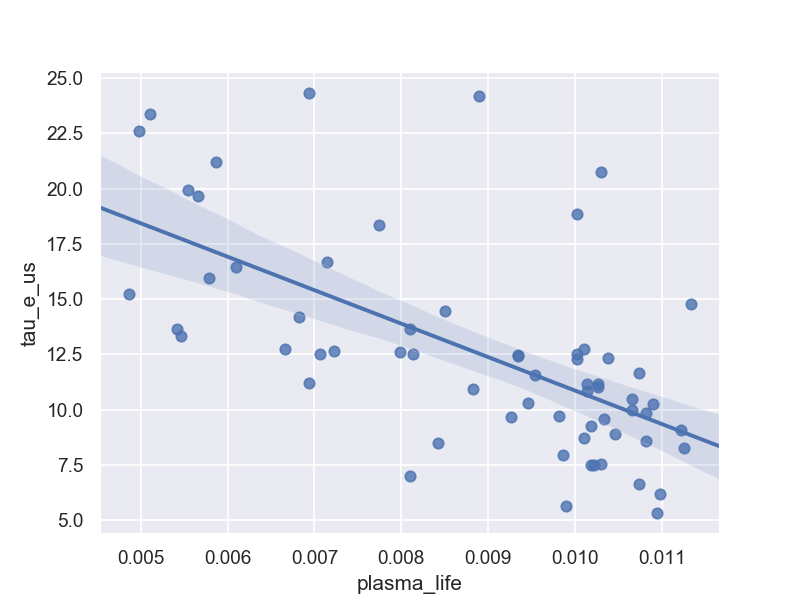

In [23]:
plt.figure()
sb.regplot(x='plasma_life', y='tau_e_us', data=sub_ds)

However, there is clear increase of the confinement time with density (pressure)

<IPython.core.display.Javascript object>


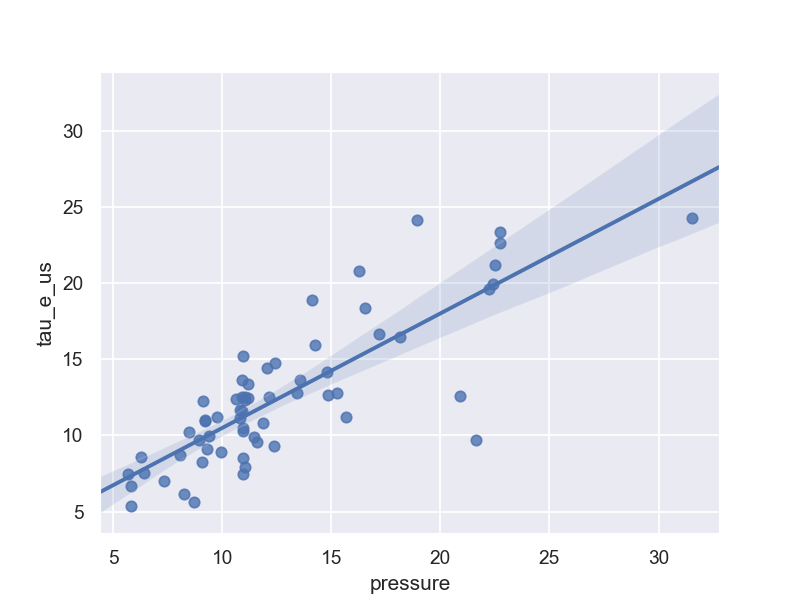

C:\Users\JH218595\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [24]:
plt.figure()
sb.regplot(x='pressure', y='tau_e_us', data=sub_ds)

<IPython.core.display.Javascript object>


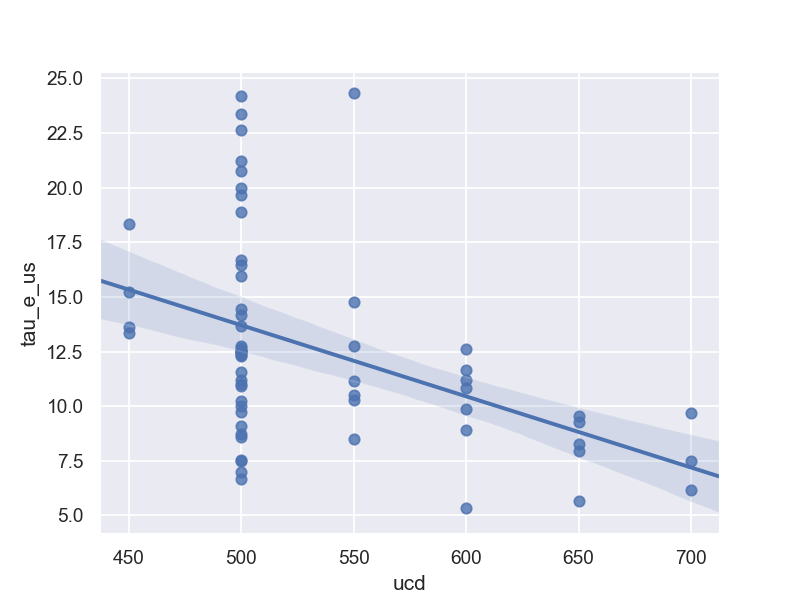

In [25]:
plt.figure()
sb.regplot(x='ucd', y='tau_e_us', data=sub_ds)

The pair plot below tells us that both the confinement time and the plasma duration are relatievly independant of the parameter $\tau_{cd}$

<IPython.core.display.Javascript object>


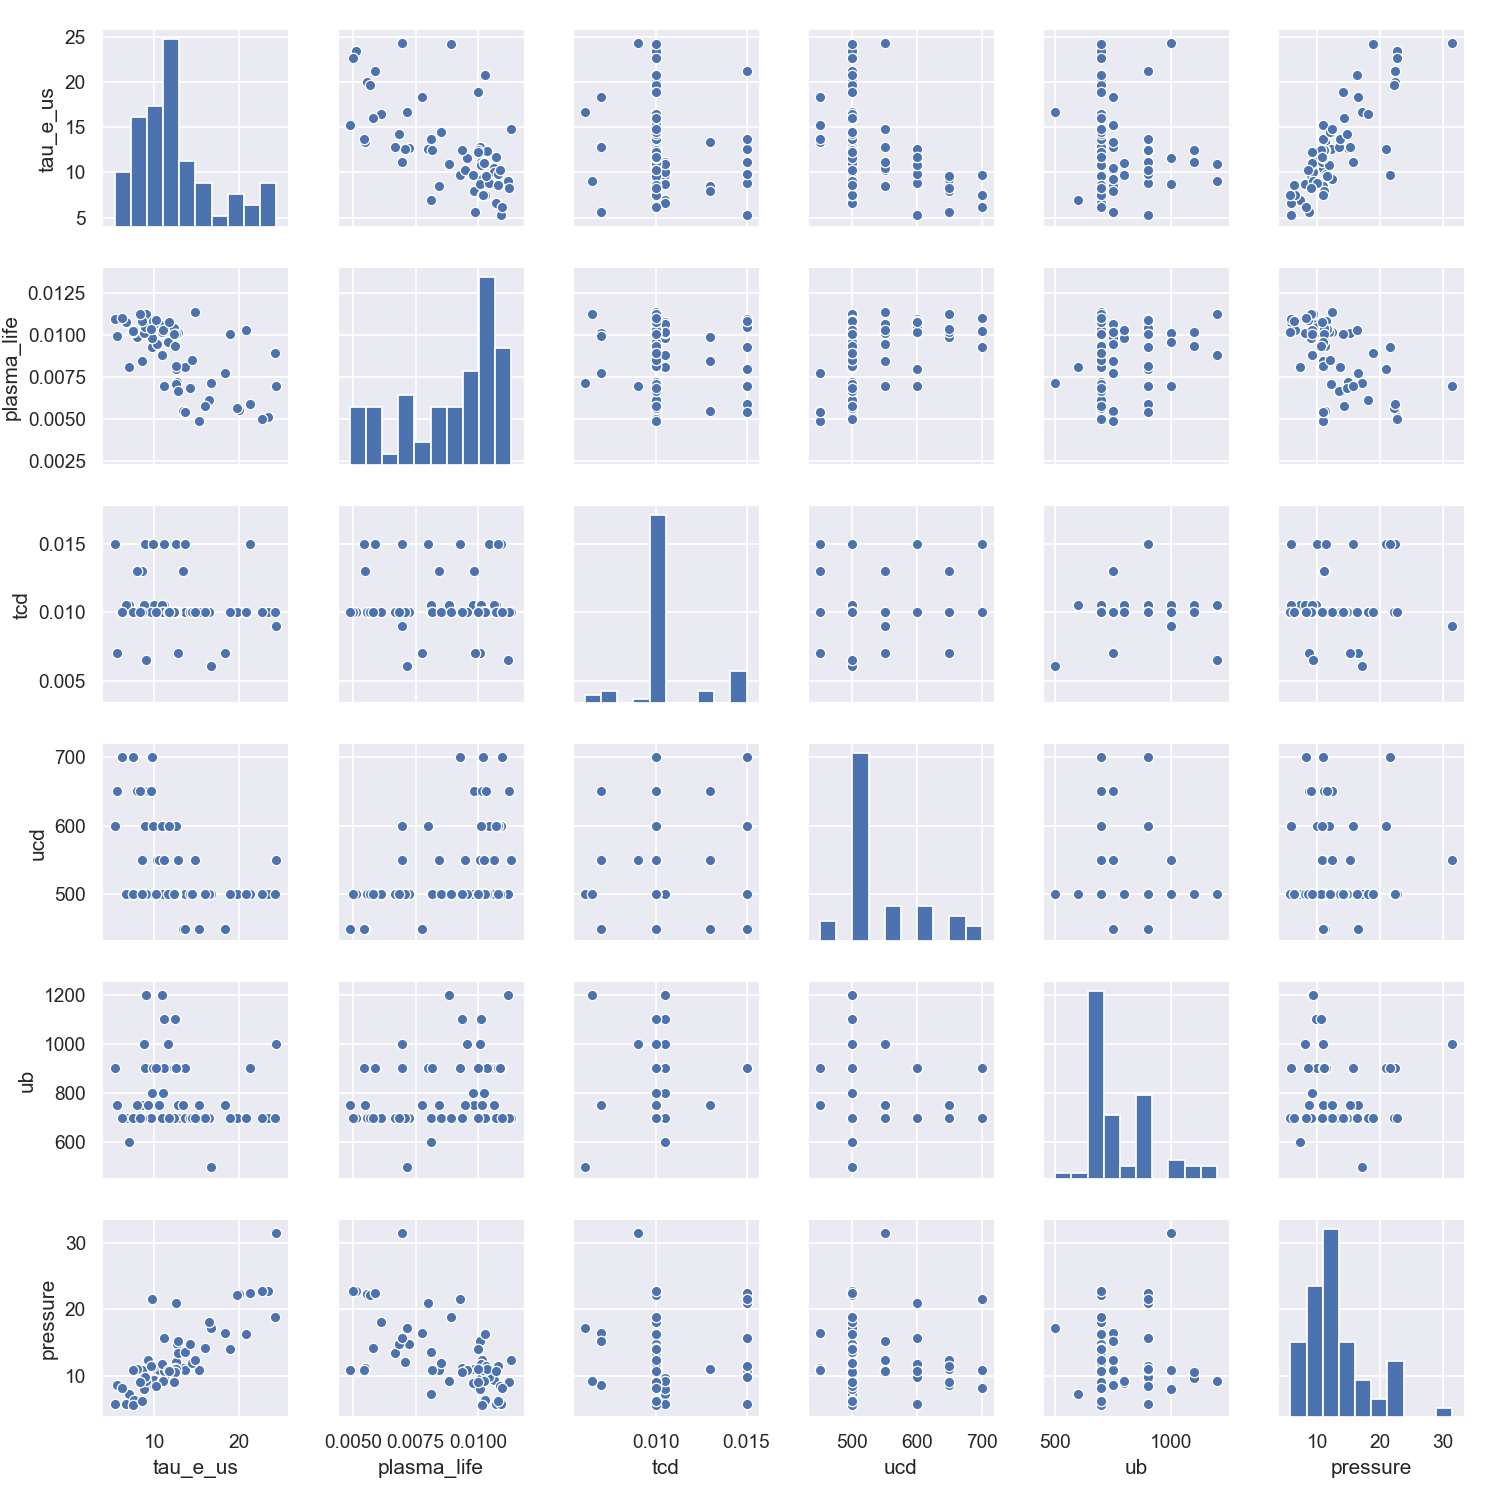

In [18]:
sb.pairplot(sub_ds, height=2)

In [ ]:
pd.plotting.scatter_matrix(sub_ds, c='r', figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

In [ ]:
sub_ds[(sub_ds['tcd'] == 0.01)]